In [217]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd
import random
from cfde import Simple_CF_Descent

%load_ext autoreload
%autoreload 2 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Naive CF-Descent

This file contains the initial attempts at making CF-Descent work and tests to see it's validity

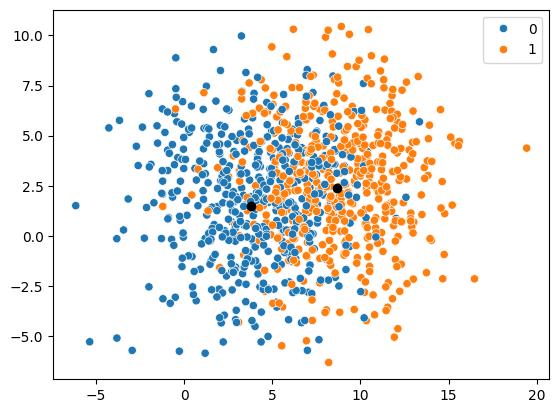

In [218]:
X, y, centers = make_blobs(centers=2, cluster_std=3, n_features=2, n_samples=1000, return_centers=True)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.scatter(x=centers[0][0], y=centers[0][1],color="black")
plt.scatter(x=centers[1][0], y=centers[1][1],color="black")

In [219]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,label
0,8.603313,4.240737,0.0
1,4.301504,-2.541818,0.0
2,1.515317,-0.232998,0.0
3,4.428581,2.546409,0.0
4,8.110436,3.705715,0.0
...,...,...,...
995,5.373811,-0.068844,1.0
996,8.706741,7.916744,1.0
997,5.306158,-0.113037,1.0
998,1.355922,1.243524,1.0


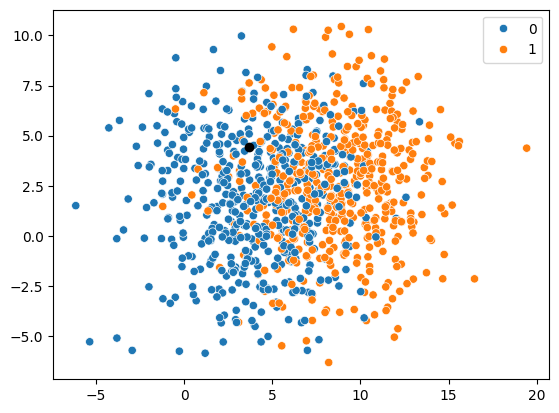

In [220]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pred)
plt.scatter(x=df.values[5][0],y=df.values[5][1],color='black')

In [221]:
x,cf,h = Simple_CF_Descent(df=df, target=1.0, centers=centers)

1.0
1.0
1.0
1.0
1.0
1.001
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.

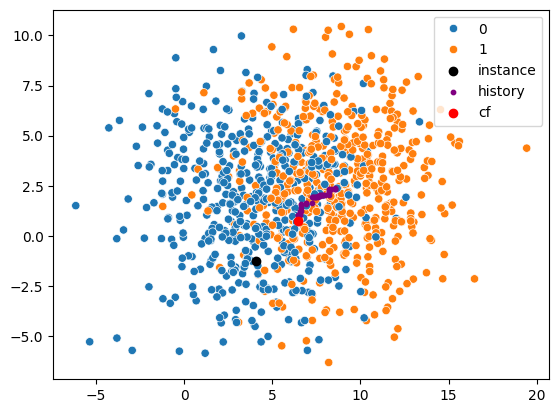

In [222]:
hx = list(zip(*h))[0]
hy = list(zip(*h))[1]
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pred)
plt.scatter(x=x[0],y=x[1],color='black',label='instance')
plt.scatter(x=hx, y=hy, color='purple', label='history',s=10)
plt.scatter(x=cf[0],y=cf[1],color='red', label='cf')
plt.legend()

## PCA attempt

<Axes: >

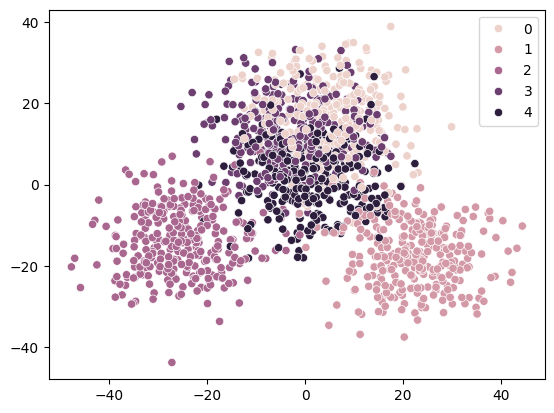

In [223]:
X, y, centers = make_blobs(centers=5, cluster_std=8, n_features=30, n_samples=1500, return_centers=True)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [224]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,label
0,4.145700,6.092522,-3.255068,-2.868462,17.794256,1.307944,-11.938537,-11.839896,-1.584635,5.145073,...,-10.572556,8.605157,-5.113693,4.786266,3.108980,-5.015463,10.892480,-7.253675,-5.627730,0.0
1,6.662070,-9.542602,3.857760,0.005872,-3.432326,17.719004,0.399072,6.230770,-20.156268,-4.928086,...,-10.345452,6.341789,-0.233993,0.057172,5.465338,-18.985232,-16.331660,0.250538,7.101560,3.0
2,-14.503212,4.029418,13.313745,-9.030172,3.419946,15.489552,0.680289,4.275446,6.526049,0.072837,...,-20.955693,5.257159,5.934786,10.841854,13.425544,-8.277118,2.392527,5.690217,-3.586519,1.0
3,7.964671,2.652619,4.725610,4.514358,14.763869,-5.923726,2.370134,-7.812714,-11.593722,-3.643244,...,0.137218,-9.817114,-1.648965,9.181926,8.417032,0.677712,-12.969066,-8.618624,-5.315921,0.0
4,-4.110460,-1.837300,5.360848,5.706597,-12.012790,0.572303,4.247039,5.972293,3.614274,-5.380483,...,-7.123921,-17.964983,2.230784,10.554190,1.442207,-24.475228,-16.158995,5.637425,-15.400276,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-3.636588,-5.946057,4.940801,-1.402688,2.660658,-1.577141,4.699188,-0.794634,-19.756591,6.452128,...,7.804155,12.358312,-2.562231,-4.309368,-2.144593,0.152247,9.013002,2.257892,-14.247204,2.0
1496,-4.509274,-8.151987,12.385053,1.778489,-13.160757,-3.161883,4.609822,9.215469,9.850962,-13.102484,...,0.935529,-0.400599,6.909831,-14.729953,2.415162,-9.142192,-16.876009,-6.506731,-5.396910,1.0
1497,4.554388,-15.268881,-4.540663,-7.143527,-2.778014,10.763836,0.539862,1.956759,2.491901,-20.715888,...,-0.365360,-8.963478,-9.819928,3.093824,16.929067,-7.540052,2.570689,-2.400047,11.821255,3.0
1498,3.981015,11.065974,11.887075,-13.001114,-8.396598,-1.688677,19.721518,-5.225543,1.108160,-5.590416,...,-12.385231,-7.941336,8.434797,-7.162754,14.215516,2.195611,-12.371638,6.647807,5.785820,1.0


In [225]:
x,cf,h = Simple_CF_Descent(df=df, target=1.0, centers=centers)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.001
1.001
1.001
1.001
1.001
1.001
1.0
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.001
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0
1.0
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0020009999999997
1.0
1.0
1.0020009999999997
1.0020009999999997
1.

In [226]:
cf_pca = pca.transform([cf])[0]

h_pca = pca.transform(h)

hx = list(zip(*h_pca))[0]
hy = list(zip(*h_pca))[1]

x_pca = pca.transform([x])[0]

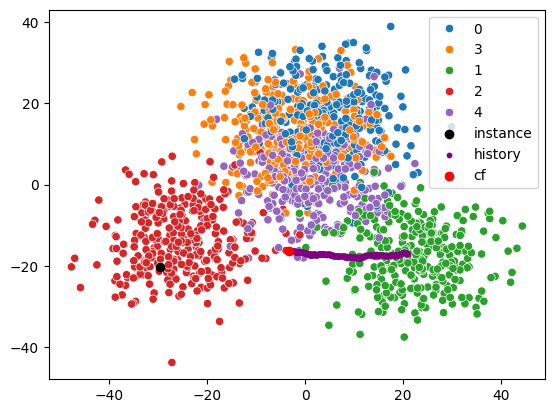

In [227]:

sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)
plt.scatter(x=x_pca[0],y=x_pca[1],color='black',label='instance')
plt.scatter(x=hx, y=hy, color='purple', label='history',s=10)
plt.scatter(x=cf_pca[0],y=cf_pca[1],color='red', label='cf')
plt.legend()